In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [3]:
from collections import Counter, OrderedDict
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold
from tqdm.auto import tqdm

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit, EnsembleTrainer, get_default_config
from meta import compute_meta_data
from metric import optimize_rounding_bounds, make_cappa_metric
from normalize import normalize

## Prepare Data

In [3]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

In [4]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 19) (1156414, 19)


In [5]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [6]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta),
    F.FeedbackFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [7]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


## Submission

In [4]:
X_trn = pd.read_pickle('/tmp/X_trn.pickle')
X_tst = pd.read_pickle('/tmp/X_tst.pickle')

In [22]:
algo = 'lightgbm'
version = '021'

U.log('Loading relevant features list from disk.')
features = [c for c in X_trn.columns 
            if c not in ('installation_id', 'game_session', 'accuracy_group')]
U.log(f'Total number of features: {len(features)}')

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    bounds = bundle.bounds()
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log(f'Training model: {algo}')
    cappa = make_cappa_metric(X_trn['accuracy_group'])
    trainer = EnsembleTrainer(algo=algo, cv_metrics={'cappa': cappa})
    fold = GroupKFold(n_splits=5)
    config = get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.5)
    U.set_nested(config, 'model_params.bagging_fraction', 0.5)
    U.set_nested(config, 'model_params.learning_rate', 0.003)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(X_trn, features=features, fold=fold, config=config)
    U.log('Saving the trained models')
    bundle.save(result.models, f'models_{algo}_{version}')
    U.log('Saving the optimal rounding bounds')
    bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    U.log(f'Optimal bounds: {bounds}')
    bundle.save(bounds, 'bounds')

Loading relevant features list from disk.
Total number of features: 1017
Training model: lightgbm
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.17672	val's rmse: 1.18593
[200]	trn's rmse: 1.11692	val's rmse: 1.13068
[300]	trn's rmse: 1.07252	val's rmse: 1.0909
[400]	trn's rmse: 1.03928	val's rmse: 1.06257
[500]	trn's rmse: 1.01117	val's rmse: 1.03984
[600]	trn's rmse: 0.989669	val's rmse: 1.02333
[700]	trn's rmse: 0.972189	val's rmse: 1.01092
[800]	trn's rmse: 0.957964	val's rmse: 1.00189
[900]	trn's rmse: 0.945652	val's rmse: 0.994829
[1000]	trn's rmse: 0.93478	val's rmse: 0.989016
[1100]	trn's rmse: 0.925694	val's rmse: 0.984744
[1200]	trn's rmse: 0.917438	val's rmse: 0.981113
[1300]	trn's rmse: 0.910309	val's rmse: 0.978574
[1400]	trn's rmse: 0.903554	val's rmse: 0.976581
[1500]	trn's rmse: 0.897332	val's rmse: 0.97493
[1600]	trn's rmse: 0.891442	val's rmse: 0.973439
[1700]	trn's rmse: 0.88591	val's rmse: 0.972467
[1800]	trn

In [27]:
from metric import PredictionsRoudner

In [28]:
rounder = PredictionsRoudner(train_target=X_trn['accuracy_group'])

In [30]:
preds, bounds_dist = rounder(result.oof)

In [31]:
bounds_dist

[1.3515825283399336, 1.8037354713648037, 2.065028190612793]

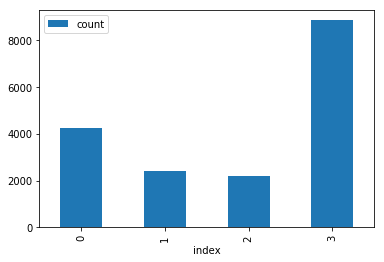

In [40]:
(pd.Series(preds)
 .value_counts()
 .rename('count')
 .reset_index()
 .sort_values(by='index')
 .plot.bar(x='index', y='count'))

In [42]:
if not U.on_kaggle():
    import os
    #features = bundle.features()
    # bounds = bundle.bounds()
    bounds = bounds_dist
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 1017
Loading external models: lightgbm v021.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/models_lightgbm_021.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_021.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/bowl2019/external/encoders.joblib
Packaging helper scripts into dataset.
../selection.py --> /home/ck/data/bowl2019/external/selection.py
../encode.py --> /home/ck/data/bowl2019/external/encode.py
../features.py --> /home/ck/data/bowl2019/external/features.py
../training.py --> /home/ck/data/bowl2019/external/

In [43]:
%matplotlib inline

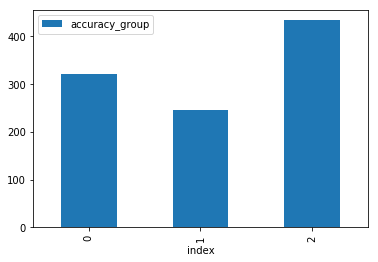

In [44]:
pd.read_csv('submission.csv')['accuracy_group'].value_counts().reset_index().sort_values(by='index').set_index('index').plot.bar()

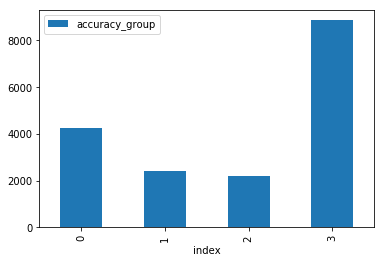

In [45]:
X_trn['accuracy_group'].value_counts().reset_index().sort_values(by='index').set_index('index').plot.bar()